# Adverse Drug Event Detection using Classical NLP

## Load the ADE-Corpus-V2 dataset

In [1]:
import pandas as pd

# load the dataset #
df = pd.read_parquet("hf://datasets/ade-benchmark-corpus/ade_corpus_v2/Ade_corpus_v2_classification/train-00000-of-00001.parquet")
df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text,label
0,Intravenous azithromycin-induced ototoxicity.,1
1,"Immobilization, while Paget's bone disease was...",1
2,Unaccountable severe hypercalcemia in a patien...,1
3,METHODS: We report two cases of pseudoporphyri...,1
4,METHODS: We report two cases of pseudoporphyri...,1


## EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23516 entries, 0 to 23515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23516 non-null  object
 1   label   23516 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.6+ KB
None
                                                text  label
0      Intravenous azithromycin-induced ototoxicity.      1
1  Immobilization, while Paget's bone disease was...      1
2  Unaccountable severe hypercalcemia in a patien...      1
3  METHODS: We report two cases of pseudoporphyri...      1
4  METHODS: We report two cases of pseudoporphyri...      1
text     0
label    0
dtype: int64
              label
count  23516.000000
mean       0.290058
std        0.453798
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
label
0    16695
1     6821
Name: count, dtype: int64


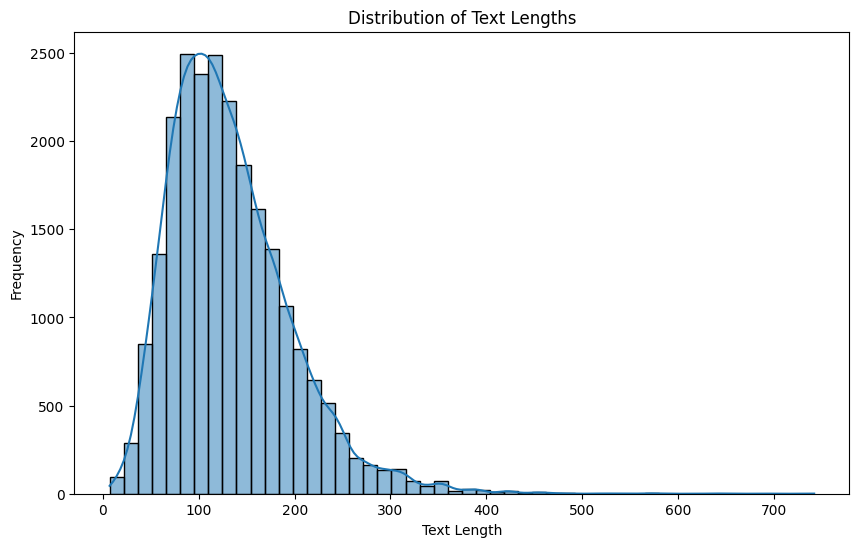

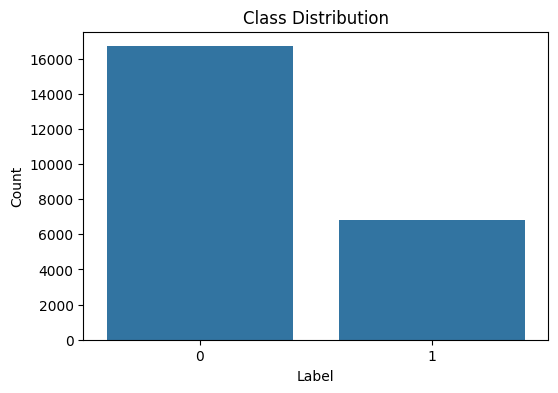

In [2]:
print(df.info())
print(df.head())
print(df.isnull().sum())
print(df.describe())
print(df['label'].value_counts())

# plot the distribution of text length #
import matplotlib.pyplot as plt
import seaborn as sns

df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# plot the class distribution #
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## EDA Conclusions:
### The dataset contains no missing values
### The text lengths vary widely, with most texts being relatively short (fewer than 400 words)
### The dataset is imbalanced, with more instances of one class compared to the other

## Split the dataset into training, validation, and test sets

In [3]:
from sklearn.model_selection import train_test_split

# stratified split #
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# check the distribution of classes in each split #
print(train_df['label'].value_counts(normalize=True))
print(val_df['label'].value_counts(normalize=True))
print(test_df['label'].value_counts(normalize=True))

label
0    0.70992
1    0.29008
Name: proportion, dtype: float64
label
0    0.709952
1    0.290048
Name: proportion, dtype: float64
label
0    0.710034
1    0.289966
Name: proportion, dtype: float64


## Convert the pandas DataFrames into TensorFlow datasets
## Shuffle the training data but keep the validation and test data in order

In [4]:
import tensorflow as tf

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('label')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# convert dataframes to tensorflow datasets #
batch_size = 32
train_ds = df_to_dataset(train_df, shuffle=True, batch_size=batch_size)
val_ds = df_to_dataset(val_df, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test_df, shuffle=False, batch_size=batch_size)

## Define custom standardization and tokenization functions for the text data
## The standardization function should convert text to lowercase and remove punctuation
## The tokenization function should split the text into words

In [5]:
import string

def custom_standardization(input_text):
    lowercase = tf.strings.lower(input_text)
    return tf.strings.regex_replace(lowercase, f'[{string.punctuation}]', '')

def custom_tokenizer(input_text):
    return tf.strings.split(input_text)

## Implement a text vectorization layer with the following configurations:
### Multi-hot encoding with unigrams
### Multi-hot encoding with bigrams
### TF-IDF encoding with bigrams
### Use a vocabulary size of 15,000

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# custom standardization and tokenization functions #
def custom_standardization(input_text):
    lowercase = tf.strings.lower(input_text)
    return tf.strings.regex_replace(lowercase, f'[{string.punctuation}]', '')

def custom_tokenizer(input_text):
    return tf.strings.split(input_text)

# configurations for text vectorization #
vocab_size = 15000

# multi-hot encoding with unigrams #
unigram_vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='multi_hot',
    standardize=custom_standardization,
    split=custom_tokenizer
)

# multi-hot encoding with bigrams #
bigram_vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='multi_hot',
    ngrams=2,
    standardize=custom_standardization,
    split=custom_tokenizer
)

# tf-idf encoding with bigrams #
tfidf_bigram_vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='tf_idf',
    ngrams=2,
    standardize=custom_standardization,
    split=custom_tokenizer
)

# adapt the vectorizers on the training data #
train_text = train_df['text'].values
unigram_vectorizer.adapt(train_text)
bigram_vectorizer.adapt(train_text)
tfidf_bigram_vectorizer.adapt(train_text)

## Apply the text vectorization layer to the training, validation, and test datasets for each configuration

In [8]:
# function to vectorize the datasets #
def vectorize_text(vectorizer, text, label):
    text = tf.expand_dims(text['text'], -1)
    return vectorizer(text), label

# vectorize the datasets for each configuration #
train_ds_unigram = train_ds.map(lambda x, y: vectorize_text(unigram_vectorizer, x, y))
val_ds_unigram = val_ds.map(lambda x, y: vectorize_text(unigram_vectorizer, x, y))
test_ds_unigram = test_ds.map(lambda x, y: vectorize_text(unigram_vectorizer, x, y))

train_ds_bigram = train_ds.map(lambda x, y: vectorize_text(bigram_vectorizer, x, y))
val_ds_bigram = val_ds.map(lambda x, y: vectorize_text(bigram_vectorizer, x, y))
test_ds_bigram = test_ds.map(lambda x, y: vectorize_text(bigram_vectorizer, x, y))

train_ds_tfidf = train_ds.map(lambda x, y: vectorize_text(tfidf_bigram_vectorizer, x, y))
val_ds_tfidf = val_ds.map(lambda x, y: vectorize_text(tfidf_bigram_vectorizer, x, y))
test_ds_tfidf = test_ds.map(lambda x, y: vectorize_text(tfidf_bigram_vectorizer, x, y))

## Define a neural network model with an input layer, a dense hidden layer with ReLU activation, a dropout layer, and an output layer with sigmoid activation
## Compile the model with the RMSprop optimizer, binary crossentropy loss, and accuracy metric

In [9]:
from tensorflow.keras import layers

def create_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(vocab_size,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

model_unigram = create_model()
model_bigram = create_model()
model_tfidf = create_model()

## Train the model for each text vectorization configuration using the training and validation datasets
## Save the best model based on validation accuracy during training

In [11]:
# training parameters #
epochs = 10

# train and validate the model with unigram vectorization #
history_unigram = model_unigram.fit(
    train_ds_unigram,
    validation_data=val_ds_unigram,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model_unigram.keras', save_best_only=True, monitor='val_accuracy')]
)

# train and validate the model with bigram vectorization #
history_bigram = model_bigram.fit(
    train_ds_bigram,
    validation_data=val_ds_bigram,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model_bigram.keras', save_best_only=True, monitor='val_accuracy')]
)

# train and validate the model with tf-idf bigram vectorization #
history_tfidf = model_tfidf.fit(
    train_ds_tfidf,
    validation_data=val_ds_tfidf,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model_tfidf.keras', save_best_only=True, monitor='val_accuracy')]
)

Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.7619 - loss: 0.5148 - val_accuracy: 0.8489 - val_loss: 0.3682
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.8669 - loss: 0.3366 - val_accuracy: 0.8582 - val_loss: 0.3460
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.8802 - loss: 0.2916 - val_accuracy: 0.8653 - val_loss: 0.3328
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.8966 - loss: 0.2653 - val_accuracy: 0.8718 - val_loss: 0.3314
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.9121 - loss: 0.2361 - val_accuracy: 0.8750 - val_loss: 0.3289
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step - accuracy: 0.9141 - loss: 0.2261 - val_accuracy: 0.8741 - val_loss: 0.3285
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.9278 - loss: 0.1988 - val_accuracy: 0.8795 - val_loss: 0.3307
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.9313 - loss: 0.1915 - 

## Evaluate the models on the test dataset and report the test accuracy, F1 score, and confusion matrix

In [14]:
from sklearn.metrics import f1_score, confusion_matrix

def evaluate_model(model, model_path, test_ds):
    model.load_weights(model_path)
    test_loss, test_acc = model.evaluate(test_ds)
    print(f'Test Accuracy: {test_acc}')

    # predict the labels #
    y_true = []
    y_pred = []
    for x, y in test_ds:
        y_true.extend(y.numpy())
        y_pred.extend((model.predict(x, verbose=0) > 0.5).astype("int32"))

    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix:\n {cm}')

# evaluate each model #
evaluate_model(model_unigram, 'best_model_unigram.keras', test_ds_unigram)
evaluate_model(model_bigram, 'best_model_bigram.keras', test_ds_bigram)
evaluate_model(model_tfidf, 'best_model_tfidf.keras', test_ds_tfidf)

111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.8825 - loss: 0.3277
Test Accuracy: 0.8795351386070251
F1 Score: 0.7771368641845832
Confusion Matrix:
 [[2362  143]
 [ 282  741]]
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8849 - loss: 0.3619
Test Accuracy: 0.8815192580223083
F1 Score: 0.7816091954022988
Confusion Matrix:
 [[2362  143]
 [ 275  748]]
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.8941 - loss: 0.3905
Test Accuracy: 0.8914399147033691
F1 Score: 0.8040920716112533
Confusion Matrix:
 [[2359  146]
 [ 237  786]]


### Based on the evaluation results, the best-performing model is the one using TF-IDF bigram vectorization. This model achieved the highest test accuracy and F1 score --> Test Accuracy: 0.8914, F1 Score: 0.8041, confusion matrix indicates a balance between true positives and true negatives with fewer false negatives compared to the other models. To further improve the performance of the TF-IDF bigram model, some strategies we can consider include hyperparameter tuning (experiment with different hyperparameters such as learning rate, dropout rate, and batch size; use techniques like grid search or random search to find the optimal hyperparameters), reworking the model architecture (increase the complexity of the model by adding more hidden layers or increasing the number of units in each layer), data augmentation (perform data augmentation techniques like synonym replacement, random insertion, or random deletion to generate more training data), and ensemble methods (combine predictions from multiple models {e.g., unigram, bigram, and TF-IDF bigram} using ensemble techniques like bagging, boosting, or stacking).